In [1]:
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import factorial
from scipy import optimize
from scipy.stats import poisson as pois
#from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec
from lmfit import Model

/home/edi/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
run_list =[389,404,392,407,394,409,395,411,397,413,399,415,401] # nome di tutte le run

def load_dataset(run):
    file = f'db/AnalyzedDataFFT_Run_{run}_sliced.xlsx'
    meta = pd.read_excel(file,sheet_name=0,header=None)
    freq = pd.read_excel(file,sheet_name=1)
    fft = pd.read_excel(file,sheet_name=2)
    
    data = pd.DataFrame({'freq':freq[1]})
    
    col = 0
    for col_name in fft.columns: # to load all the subrun
        if col > 0:
            data[f'fft{col-1}'] = fft[col_name]
        col += 1
    
    center = meta[1][3]
    
    print(f'dataset loaded: {file}\ncavity frequency: {center} Hz\nfft subrun:{len(data.columns)-1}')
    
    return data,center

def fit_func(x,a,b,c,d,e,f):
    return e**2*abs(x-a+1j*b)**2/abs(x-c+1j*d)**2+f*(x-c)

def fit(alldata,center,subrun=0, B=651, width=100):
    
    # pesi
    L = len(alldata['freq'])
    pesi = np.zeros(L)
    for i in range(L):
        pesi[i] = alldata[f'fft{subrun}'][i]/np.sqrt(1365500) # 1365500 vale solo per le run: 389,392,394,397,404
        #pesi[i] = alldata[f'fft{subrun}'][i]/np.sqrt(1365500) # 2731?? sono i millikelvin?
        
    mask = (alldata['freq']>center-B*width) & (alldata['freq']<center+B*width)
    rawdata = alldata[mask] # finestra di 200 bin ognuno da 651 Hz
    pesi = pesi[mask]
    
    # scalo in potenze di yottowat
    #display(rawdata)
    minW = rawdata.iloc[ np.argmin(rawdata[f'fft{subrun}']),subrun + 1 ] # potenza nel minimo della cavità = rv[100]
    ref = minW**(-1) * 3.5*1.38e-23*651/1e-24
    data = rawdata.copy()
    data[f'fft{subrun}'] = ref * rawdata[f'fft{subrun}']
    #print('dopo aver scalato')
    #display(data)
    
    
    freq = data['freq']
    fmin,fmax = min(freq),max(freq)
    fft=data[f'fft{subrun}']

    # fit
    fmodel = Model(fit_func)
    ps = fmodel.make_params(a=center, b=2e4, c=center,d=2.2e4,e=1e-2*np.sqrt(ref),f=1e-12*ref)
    ps.add('a', value=center, min=center*0.999, max=center*1.01)
    ps.add('c', value=center, min=center*0.999, max=center*1.01)

    pesi = pesi*ref # scalo anche i pesi
    result = fmodel.fit(fft,x=freq, params=ps, weights=1/pesi) # aggiungere i pesi non cambia i parametri del fit,
                                                             # nè il loro errore, 
                                # per aggiungerli dopo aver scalato i dati bisogna capire np.sqrt(length*2731)
    
    fig = plt.figure(figsize=(15,10))
    
    gs = GridSpec(2, 2)
    ax = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1])
    
    ax.plot(freq,fft,'o',label='data')
    ax.plot(freq,result.best_fit, color="red", label='fit')
    #ax.set_ylim([4e-5,7e-5])
    ax.set_xlim([fmin,fmax])
    ax.legend()
    
    
    result.plot_residuals(ax=ax1,yerr=pesi)
    ax2.hist(result.residual)
    
    plt.show()
    
    return(result)

# per caricare tutte le run

def load_all():
    for i in run_list:
        data,center = load_dataset(389)
        for j in range(len(data.columns)-1):
            result = fit(data,center,width=200,subrun=j)
            print(result.residual[0])

In [3]:
!ls db

AnalyzedDataFFT_Run_389_sliced.xlsx  AnalyzedDataFFT_Run_404_sliced.xlsx
AnalyzedDataFFT_Run_392_sliced.xlsx  AnalyzedDataFFT_Run_407_sliced.xlsx
AnalyzedDataFFT_Run_394_sliced.xlsx  AnalyzedDataFFT_Run_409_sliced.xlsx
AnalyzedDataFFT_Run_395_sliced.xlsx  AnalyzedDataFFT_Run_411_sliced.xlsx
AnalyzedDataFFT_Run_397_sliced.xlsx  AnalyzedDataFFT_Run_413_sliced.xlsx
AnalyzedDataFFT_Run_399_sliced.xlsx  AnalyzedDataFFT_Run_415_sliced.xlsx
AnalyzedDataFFT_Run_401_sliced.xlsx


In [4]:
# se c'è più di una subrun vengono caricate tutte in colonne diverse di nome fft{i}
data,center = load_dataset(395)
data

dataset loaded: db/AnalyzedDataFFT_Run_395_sliced.xlsx
cavity frequency: 10353468841.0 Hz
fft subrun:2


,freq,fft0,fft1
0,1.035200e+10,0.000048,0.000049
1,1.035200e+10,0.000048,0.000049
2,1.035200e+10,0.000048,0.000049
3,1.035200e+10,0.000048,0.000049
4,1.035200e+10,0.000048,0.000049
...,...,...,...
3067,1.035400e+10,0.000048,0.000049
3068,1.035400e+10,0.000048,0.000049
3069,1.035400e+10,0.000048,0.000049
3070,1.035400e+10,0.000048,0.000049


In [5]:
# provo finestre di diverse lunghezze

#data,center = load_dataset(389)
#
#for i in range(100,500,100):
#    print('\n\n*****************************************************************')
#    print(f'*******   RUN with window of {2*i} bin length   *****************')
#    print('*****************************************************************')
#    result = fit(data,center,width=i)
#    print('---------------')
#    print('chi-square',result.chisqr)

Fino a +200 -200 si ottiene un ottimo fit

dataset loaded: db/AnalyzedDataFFT_Run_389_sliced.xlsx
cavity frequency: 10353522551.0 Hz
fft subrun:1


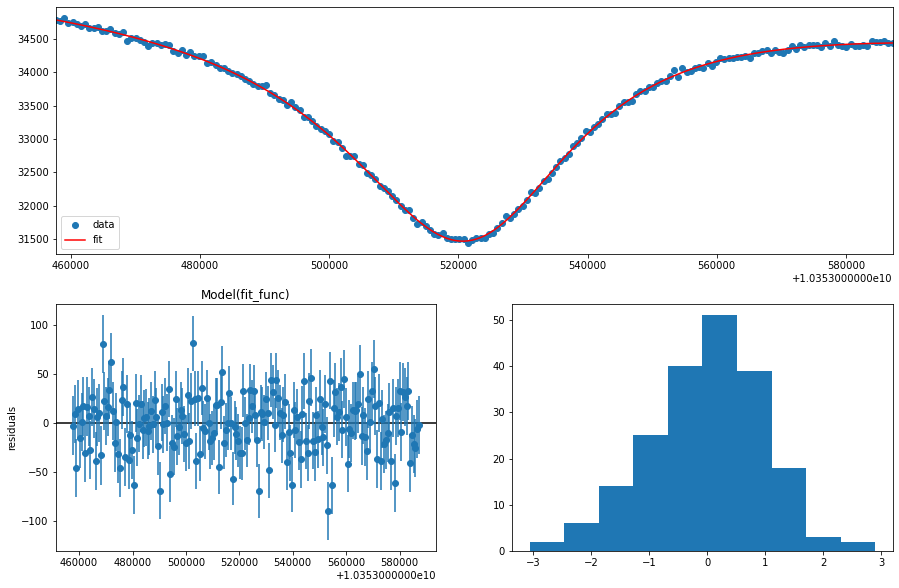

In [101]:
data,center = load_dataset(389)
result = fit(data,center, width=100)